In [ ]:
!pip install biopython freesasa requests rarfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.2 MB/s eta 0:00:00
  Created wheel for freesasa: filename=freesasa-2.2.1-cp310-cp310-linux_x86_64.whl size=853079 sha256=d34db01a821fc0fe986277479267323c29ce430dbfe4a6696881291fce8b1a9c
  Stored in directory: /root/.cache/pip/wheels/ef/f5/89/77b77735ac804410dd420a5a8ed504321ad051cf65dd3d1f9f
Successfully built freesasa


In [ ]:
!git clone https://github.com/jianzhong123/RGCNPPIS.git

Cloning into 'RGCNPPIS'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 126 (delta 17), reused 0 (delta 0), pack-reused 77 (from 1)
Receiving objects: 100% (126/126), 127.51 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
# List of pickle file paths
import pickle
import os

def load_pickle(file_path):
    """
    Load a pickle file and return its contents.

    Parameters:
    - file_path (str): Path to the pickle file.

    Returns:
    - dict: The dictionary loaded from the pickle file.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'rb') as file:
        try:
            data = pickle.load(file)
            if not isinstance(data, dict):
                raise ValueError(f"The file {file_path} does not contain a dictionary.")
            return data
        except pickle.UnpicklingError as e:
            raise ValueError(f"Error  unpickling file {file_path}: {e}")


file_paths = [
    '/content/RGCNPPIS/Dataset/train_186_164.pkl',
    '/content/RGCNPPIS/Dataset/test_71.pkl',
    '/content/RGCNPPIS/Dataset/Test_315.pkl'
]

# Load each pickle file into a list of dictionaries
loaded_dicts = []
for path in file_paths:
    try:
        data = load_pickle(path)
        loaded_dicts.append(data)
        print(f"Successfully loaded {path}")
    except (FileNotFoundError, ValueError) as e:
        print(f"Error loading {path}: {e}")
from collections import defaultdict

combined_dict = defaultdict(list)

for d in loaded_dicts:
    for key, value in d.items():
        combined_dict[key].append(value)

# Convert defaultdict back to a regular dict if desired
combined_dict = dict(combined_dict)

print("Combined dictionary with lists for overlapping keys has been created.")
data = combined_dict
len(loaded_dicts[0]),len(loaded_dicts[1]),len(loaded_dicts[2]),len(combined_dict)

Successfully loaded /content/RGCNPPIS/Dataset/train_186_164.pkl
Successfully loaded /content/RGCNPPIS/Dataset/test_71.pkl
Successfully loaded /content/RGCNPPIS/Dataset/Test_315.pkl
Combined dictionary with lists for overlapping keys has been created.


(324, 71, 315, 710)

In [ ]:
# Install BioPython
# !pip install biopython

# Import necessary libraries
import os
import shutil
import pickle
import datetime
import argparse
import string
import numpy as np
import pandas as pd
from Bio import PDB
import requests
from io import BytesIO
import gzip

# Define amino acid dictionaries and error codes
aa = ["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
      "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"]
aa_abbr = [x for x in "ACDEFGHIKLMNPQRSTVWY"]
aa_dict = dict(zip(aa, aa_abbr))

error_code_dic = {
    "PDB not exist": 1,
    "chain not exist": 2,
    "PDB_seq & dismap_seq mismatch": 3,
    "DSSP too long": 4,
    "Fail to pad DSSP": 5,
    "SASA calculation mismatch": 6  # New error code for SASA mismatch
}


In [ ]:
#   # Define a unique job ID based on the current timestamp
jobID = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Define the data path
data_path = f"/content/data_{jobID}/"

# Create the directory
os.makedirs(data_path, exist_ok=True)
# or_sequence = data[ID][0][1]
# or_sequence

In [ ]:
import os
import shutil
import requests
import gzip
from io import BytesIO
from Bio import PDB
from Bio.PDB import NeighborSearch
from Bio.PDB.Polypeptide import is_aa

# Amino acid mapping dictionary (ensure you have this defined)
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def get_PDB(PDBID, pdb_file, chain, data_path):
    """
    Obtain the PDB file, extract the specified chain, retrieve the amino acid sequence,
    identify interaction sites, and classify them as obligate or non-obligate.
    """
    ID = PDBID + chain
    pdb_filename = ID + ".pdb"

    # Initialize PDB parser
    parser = PDB.PDBParser(QUIET=True)

    if PDBID.lower() == "user" and pdb_file != "":  # User custom PDB file
        # Ensure the provided file exists
        if not os.path.isfile(pdb_file):
            print("Error: Provided PDB file does not exist.")
            return "", [], [], 1  # Error code for "PDB not exist"

        # Copy the user-provided PDB file to the data_path with a standardized name
        shutil.copy(pdb_file, os.path.join(data_path, "user.pdb"))
        pdb_path = os.path.join(data_path, "user.pdb")
    else:
        # Download the PDB file from RCSB PDB
        url = f"https://files.rcsb.org/download/{PDBID.upper()}.pdb.gz"
        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error: Failed to download PDB ID {PDBID}. Status code: {response.status_code}")
            return "", [], [], 1  # Error code for "PDB not exist"

        # Decompress the PDB file
        with gzip.open(BytesIO(response.content), 'rt') as f_in:
            pdb_content = f_in.read()

        # Save the decompressed PDB file
        pdb_path = os.path.join(data_path, f"{PDBID.upper()}.pdb")
        with open(pdb_path, 'w') as f_out:
            f_out.write(pdb_content)

    try:
        # Parse the PDB file
        structure = parser.get_structure(ID, pdb_path)
    except Exception as e:
        print(f"Error parsing PDB file: {e}")
        return "", [], [], 1  # Error code for "PDB not exist"

    # Extract the specified chain
    model = structure[0]  # Assuming we're interested in the first model
    if chain not in model:
        print(f"Error: Chain {chain} not found in the PDB structure.")
        return "", [], [], 2  # Error code for "Chain not exist"

    target_chain = model[chain]

    # Extract the amino acid sequence and map residue numbers to sequence indices
    seq = ""
    residue_number_to_seq_index = {}
    seq_index = 0
    for residue in target_chain:
        # Exclude non-standard residues
        if is_aa(residue, standard=True):
            res_name = residue.get_resname()
            if res_name in aa_dict:
                seq += aa_dict[res_name]
            else:
                # Handle unknown amino acids
                seq += 'X'
            # Map residue number to sequence index
            residue_number = residue.get_id()[1]
            residue_number_to_seq_index[residue_number] = seq_index
            seq_index += 1

    if seq == "":
        print("Error: No valid amino acid sequence found in the specified chain.")
        return "", [], [], 2  # Error code for "Chain not exist"
    else:
        # Save the extracted chain as a separate PDB file
        io = PDB.PDBIO()
        io.set_structure(target_chain)
        extracted_pdb_path = os.path.join(data_path, pdb_filename)
        io.save(extracted_pdb_path)

    # Identify Interaction Sites
    # Modify the function to return sequence indices instead of residue numbers
    obligate_sites_resnum, non_obligate_sites_resnum = identify_interaction_sites(structure, target_chain)

    # Map residue numbers to sequence indices for the binding sites
    obligate_site_indices = []
    non_obligate_site_indices = []

    sequence_length = len(seq)  # Get the length of the sequence

    for resnum in obligate_sites_resnum:
        seq_idx = residue_number_to_seq_index.get(resnum)
        # Ensure the index is within the sequence bounds
        if seq_idx is not None and 0 <= seq_idx < sequence_length:
            obligate_site_indices.append(seq_idx)
        else:
            print(f"Warning: Residue number {resnum} (obligate) is out of sequence bounds.")

    for resnum in non_obligate_sites_resnum:
        seq_idx = residue_number_to_seq_index.get(resnum)
        # Ensure the index is within the sequence bounds
        if seq_idx is not None and 0 <= seq_idx < sequence_length:
            non_obligate_site_indices.append(seq_idx)
        else:
            print(f"Warning: Residue number {resnum} (non-obligate) is out of sequence bounds.")

    # Annotate the sequence
    annotated_seq = list(seq)

    # Annotate obligate sites
    for seq_index in obligate_site_indices:
        # Mark obligate sites with uppercase letters
        annotated_seq[seq_index] = annotated_seq[seq_index].upper()

    # Annotate non-obligate sites
    for seq_index in non_obligate_site_indices:
        # Mark non-obligate sites with lowercase letters
        annotated_seq[seq_index] = annotated_seq[seq_index].lower()

    # Join the annotated sequence back into a string
    annotated_seq = ''.join(annotated_seq)

    return annotated_seq, obligate_site_indices, non_obligate_site_indices, 0  # Error code 0 for success

def identify_interaction_sites(structure, target_chain, distance_cutoff=2.0, interaction_threshold=12):
    """
    Identify and classify interaction sites in the target chain.

    Returns:
    - tuple: (obligate_sites_residue_numbers (list), non_obligate_sites_residue_numbers (list))
    """
    print("Starting interaction site identification...")
    # Extract all atoms in the structure
    atoms = list(structure.get_atoms())
    print(f"Total number of atoms in structure: {len(atoms)}")
    neighbor_search = NeighborSearch(atoms)

    interaction_residues = set()

    target_chain_id = target_chain.get_id()
    print(f"Target chain ID: {target_chain_id}")

    # Iterate through residues in the target chain
    for residue in target_chain:
        if not is_aa(residue, standard=True):
            continue
        for atom in residue.get_atoms():
            # Find neighboring residues within the cutoff distance
            neighbors = neighbor_search.search(atom.get_coord(), distance_cutoff, level='R')
            for neighbor in neighbors:
                neighbor_chain = neighbor.get_parent().get_parent()
                if neighbor_chain.get_id() == target_chain_id:
                    # Skip residues in the same chain
                    continue
                if neighbor.get_parent() == residue:
                    # Skip the same residue
                    continue
                # Add the residue to the interaction set
                interaction_residues.add(residue)
                break  # No need to check other atoms in this residue

    print(f"Number of interacting residues found: {len(interaction_residues)}")

    if not interaction_residues:
        print("No interacting residues detected. Consider increasing the distance cutoff or verifying the PDB structure.")

    # Classify residues based on the number of interactions
    obligate_sites_resnum = []
    non_obligate_sites_resnum = []

    for residue in interaction_residues:
        interacting_count = 0
        for atom in residue.get_atoms():
            neighbors = neighbor_search.search(atom.get_coord(), distance_cutoff, level='R')
            for neighbor in neighbors:
                neighbor_chain = neighbor.get_parent().get_parent()
                if neighbor_chain.get_id() == target_chain_id:
                    continue
                if neighbor.get_parent() == residue:
                    continue
                interacting_count += 1
        # Classify based on the interaction count
        if interacting_count >= interaction_threshold:
            obligate_sites_resnum.append(residue.get_id()[1])  # Using residue number
        else:
            non_obligate_sites_resnum.append(residue.get_id()[1])

    print(f"Obligate interaction sites (Residue Numbers): {obligate_sites_resnum}")
    print(f"Non-Obligate interaction sites (Residue Numbers): {non_obligate_sites_resnum}")

    return obligate_sites_resnum, non_obligate_sites_resnum

index =0
ID = list(data.keys())[index]
or_sequence = data[ID][0]
# ID,or_sequence
PDBID = ID[:-1]
pdb_file = ""  # Not using a user-provided file
chain = ID[-1]
mode = "fast"  # Mode can be "fast" or "slow" based on your original script

seq, obligate_sites, non_obligate_sites, error_code = get_PDB(PDBID, pdb_file, chain, data_path)

if error_code == 0:
    print(f"Generated Sequence for {PDBID}{chain}:")
    print(seq)
else:
    print(f"Error occurred: {error_code_dic.get(error_code, 'Unknown Error')}")
print(f"Original Sequence for {PDBID}{chain}:")
print(or_sequence)
print(obligate_sites)
print(non_obligate_sites)

Starting interaction site identification...
Total number of atoms in structure: 4824
Target chain ID: B
Number of interacting residues found: 90
Obligate interaction sites (Residue Numbers): [1163, 1156, 1158, 1130, 1153, 1194]
Non-Obligate interaction sites (Residue Numbers): [1166, 1135, 1193, 1165, 1134, 1180, 1137, 1183, 1152, 1121, 1205, 1173, 1146, 1145, 1192, 1164, 1133, 1203, 1176, 1148, 1117, 1169, 1184, 1141, 1187, 1125, 1202, 1171, 1128, 1175, 1186, 1155, 1127, 1120, 1198, 1167, 1170, 1139, 1185, 1154, 1157, 1126, 1179, 1178, 1119, 1197, 1138, 1162, 1131, 1177, 1181, 1150, 1149, 1118, 1196, 1122, 1174, 1168, 1189, 1204, 1161, 1188, 1191, 1160, 1129, 1206, 1132, 1147, 1200, 1199, 1172, 1140, 1144, 1190, 1159, 1124, 1143, 1195, 1136, 1182, 1151, 1123, 1201, 1142]
Generated Sequence for 1f60B:
paaksivtldvkpWddetnleemvanvkaiemegltWgaHqFipigFgikklqincvveddkvslddlqqsieededHvqstdiaamqkl
Original Sequence for 1f60B:
['PAAKSIVTLDVKPWDDETNLEEMVANVKAIEMEGLTWGAHQFIPIGFGIKKLQINCVVEDDKVSL

In [ ]:
os.makedirs('/content/obligate_sites', exist_ok=True)
os.makedirs('/content/non_obligate_sites', exist_ok=True)
os.makedirs('/content/labels', exist_ok=True)

for ID in data:
  or_sequence = data[ID][0][1]
  PDBID = ID[:-1]
  chain = ID[-1]
  seq, obligate_sites, non_obligate_sites, error_code = get_PDB(PDBID, pdb_file, chain, data_path)

  if error_code == 0:
      np.save(f"/content/obligate_sites/{ID}.npy", obligate_sites)
      np.save(f"/content/non_obligate_sites/{ID}.npy", non_obligate_sites)
      np.save(f"/content/labels/{ID}.npy", or_sequence)
      print(f"saved {ID}.npy")
  else:
      print(f"An error occurred. Error code: {error}")

Starting interaction site identification...
Total number of atoms in structure: 4824
Target chain ID: B
Number of interacting residues found: 90
Obligate interaction sites (Residue Numbers): [1163, 1156, 1158, 1130, 1153, 1194]
Non-Obligate interaction sites (Residue Numbers): [1166, 1135, 1193, 1165, 1134, 1180, 1137, 1183, 1152, 1121, 1205, 1173, 1146, 1145, 1192, 1164, 1133, 1203, 1176, 1148, 1117, 1169, 1184, 1141, 1187, 1125, 1202, 1171, 1128, 1175, 1186, 1155, 1127, 1120, 1198, 1167, 1170, 1139, 1185, 1154, 1157, 1126, 1179, 1178, 1119, 1197, 1138, 1162, 1131, 1177, 1181, 1150, 1149, 1118, 1196, 1122, 1174, 1168, 1189, 1204, 1161, 1188, 1191, 1160, 1129, 1206, 1132, 1147, 1200, 1199, 1172, 1140, 1144, 1190, 1159, 1124, 1143, 1195, 1136, 1182, 1151, 1123, 1201, 1142]
saved 1f60B.npy
Starting interaction site identification...
Total number of atoms in structure: 4058
Target chain ID: B
Number of interacting residues found: 237
Obligate interaction sites (Residue Numbers): [178, 100

In [ ]:
import shutil
import os

def compress_folder_shutil(source_folder, output_zip):
    """
    Compresses the specified folder into a ZIP file using shutil.make_archive.

    Parameters:
    - source_folder (str): Path to the folder to compress.
    - output_zip (str): Desired path for the output ZIP file without extension.

    Returns:
    - str: Path to the created ZIP file.
    """
    # Ensure the source folder exists
    if not os.path.isdir(source_folder):
        raise FileNotFoundError(f"The folder {source_folder} does not exist.")

    # The 'base_name' should not have the .zip extension
    base_name, _ = os.path.splitext(output_zip)

    # Create the archive
    archive_path = shutil.make_archive(base_name, 'zip', source_folder)

    return archive_path


source = "/content/non_obligate_sites"  # Replace with your source folder path
output = "/content/non_obligate_sites.zip"  # Replace with your desired output path

try:
    zip_path = compress_folder_shutil(source, output)
    print(f"Folder compressed successfully into: {zip_path}")
except Exception as e:
    print(f"An error occurred: {e}")


source = "/content/obligate_sites"  # Replace with your source folder path
output = "/content/obligate_sites.zip"  # Replace with your desired output path

try:
    zip_path = compress_folder_shutil(source, output)
    print(f"Folder compressed successfully into: {zip_path}")
except Exception as e:
    print(f"An error occurred: {e}")

source = "/content/labels"  # Replace with your source folder path
output = "/content/labels.zip"  # Replace with your desired output path

try:
    zip_path = compress_folder_shutil(source, output)
    print(f"Folder compressed successfully into: {zip_path}")
except Exception as e:
    print(f"An error occurred: {e}")


Folder compressed successfully into: /content/non_obligate_sites.zip
Folder compressed successfully into: /content/obligate_sites.zip
Folder compressed successfully into: /content/labels.zip


In [ ]:
import zipfile
import os

def extract_zip(file_path, extract_to=None):
    """
    Extract a ZIP file to the specified directory.

    :param file_path: Path to the ZIP file.
    :param extract_to: Directory to extract files into. If None, extracts to the current directory.
    """
    if not extract_to:
        extract_to = os.path.dirname(file_path)

    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"ZIP file extracted successfully to: {extract_to}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid ZIP archive.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
zip_file_path = "/content/pred (1).zip"  # Replace with the path to your ZIP file
destination_folder = "/content/pred"  # Replace with the extraction destination or leave None
extract_zip(zip_file_path, destination_folder)


ZIP file extracted successfully to: /content/pred


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths to your folders
labels_folder = '/content/labels'
pred_folder = '/content/pred'
obligate_folder = '/content/obligate_sites'
non_obligate_folder = '/content/non_obligate_sites'

# Function to create a mapping from lower-case file names to actual file paths
def create_file_mapping(folder):
    files = os.listdir(folder)
    file_map = {}
    for f in files:
        if f.endswith('.npy'):
            key = f.replace('.npy', '').lower()
            file_map[key] = f
    return file_map

# Create file mappings for each folder
labels_files = create_file_mapping(labels_folder)
pred_files = create_file_mapping(pred_folder)
obligate_files = create_file_mapping(obligate_folder)
non_obligate_files = create_file_mapping(non_obligate_folder)

# Get a list of PDBIDs from labels folder (lowercased)
pdbids = list(labels_files.keys())

# Lists to store metrics
obligate_metrics = []
non_obligate_metrics = []

for pdbid in pdbids:
    # Load data
    try:
        # Get the actual file names from the mappings
        labels_file = labels_files[pdbid]
        preds_file = pred_files[pdbid]
        obligate_file = obligate_files[pdbid]
        non_obligate_file = non_obligate_files[pdbid]

        # Load data
        labels = np.load(os.path.join(labels_folder, labels_file))
        preds = np.load(os.path.join(pred_folder, preds_file))
        obligate_indices = np.load(os.path.join(obligate_folder, obligate_file))
        non_obligate_indices = np.load(os.path.join(non_obligate_folder, non_obligate_file))
        print(labels)
        print(preds)
        print(obligate_indices)
        print(non_obligate_indices)
        # Ensure indices are integers
        obligate_indices = obligate_indices.astype(int)
        non_obligate_indices = non_obligate_indices.astype(int)

        # Extract labels and predictions for obligate sites
        labels_obligate = labels[obligate_indices]
        preds_obligate = preds[obligate_indices]

        # Extract labels and predictions for non-obligate sites
        labels_non_obligate = labels[non_obligate_indices]
        preds_non_obligate = preds[non_obligate_indices]

        # Compute metrics for obligate sites
        acc_obligate = accuracy_score(labels_obligate, preds_obligate)
        prec_obligate = precision_score(labels_obligate, preds_obligate, zero_division=0)
        rec_obligate = recall_score(labels_obligate, preds_obligate, zero_division=0)
        f1_obligate = f1_score(labels_obligate, preds_obligate, zero_division=0)
        obligate_metrics.append([acc_obligate, prec_obligate, rec_obligate, f1_obligate])

        # Compute metrics for non-obligate sites
        acc_non_obligate = accuracy_score(labels_non_obligate, preds_non_obligate)
        prec_non_obligate = precision_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        rec_non_obligate = recall_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        f1_non_obligate = f1_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        non_obligate_metrics.append([acc_non_obligate, prec_non_obligate, rec_non_obligate, f1_non_obligate])

        print(f'Successfully processed {pdbid}')
    except Exception as e:
        print(f'Error processing {pdbid}: {e}')
        pass

# Convert lists to NumPy arrays for easier aggregation
obligate_metrics = np.array(obligate_metrics)
non_obligate_metrics = np.array(non_obligate_metrics)

# Compute average metrics over all PDBIDs
avg_obligate_metrics = np.mean(obligate_metrics, axis=0)
avg_non_obligate_metrics = np.mean(non_obligate_metrics, axis=0)

# Display the results
print("\nPerformance on Obligate Sites:")
print(f"Accuracy: {avg_obligate_metrics[0]:.4f}")
print(f"Precision: {avg_obligate_metrics[1]:.4f}")
print(f"Recall: {avg_obligate_metrics[2]:.4f}")
print(f"F1 Score: {avg_obligate_metrics[3]:.4f}\n")

print("Performance on Non-Obligate Sites:")
print(f"Accuracy: {avg_non_obligate_metrics[0]:.4f}")
print(f"Precision: {avg_non_obligate_metrics[1]:.4f}")
print(f"Recall: {avg_non_obligate_metrics[2]:.4f}")
print(f"F1 Score: {avg_non_obligate_metrics[3]:.4f}")


Streaming output truncated to the last 5000 lines.
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1
 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0]
[148  83  39 160 142  46   3   2 154 141 103  13 164  67 113  50  37   6
  89 128  99  40]
[ 52 120  98 166 135 101  70 114 145  85  42  11  95  64  33  63  32 132
  36   5 147  82  51  23 159 162 131 152  81 124 102  53  22 105  74  43
  12 143 111  15  93  92  61 161 130  55  24  76  45 104  73  91  14 138
 107 153 122  88  57  26 125  


Performance on Obligate Sites:
Accuracy: 0.9083
Precision: 0.8115
Recall: 0.7502
F1 Score: 0.7541

Performance on Non-Obligate Sites:
Accuracy: 0.9222
Precision: 0.7726
Recall: 0.7083
F1 Score: 0.7231


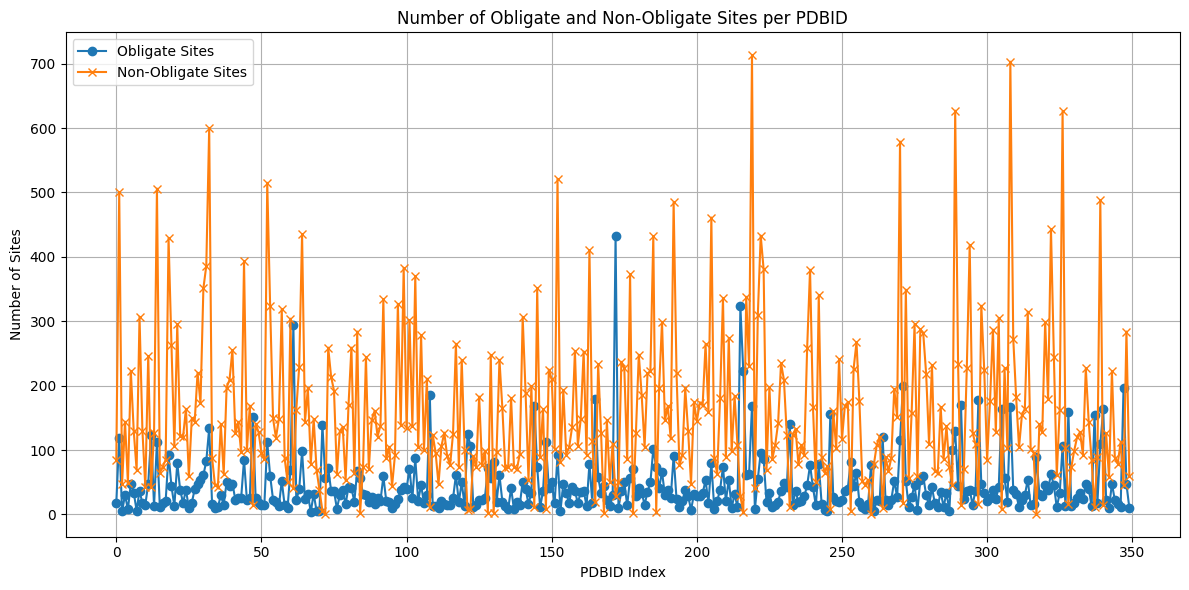

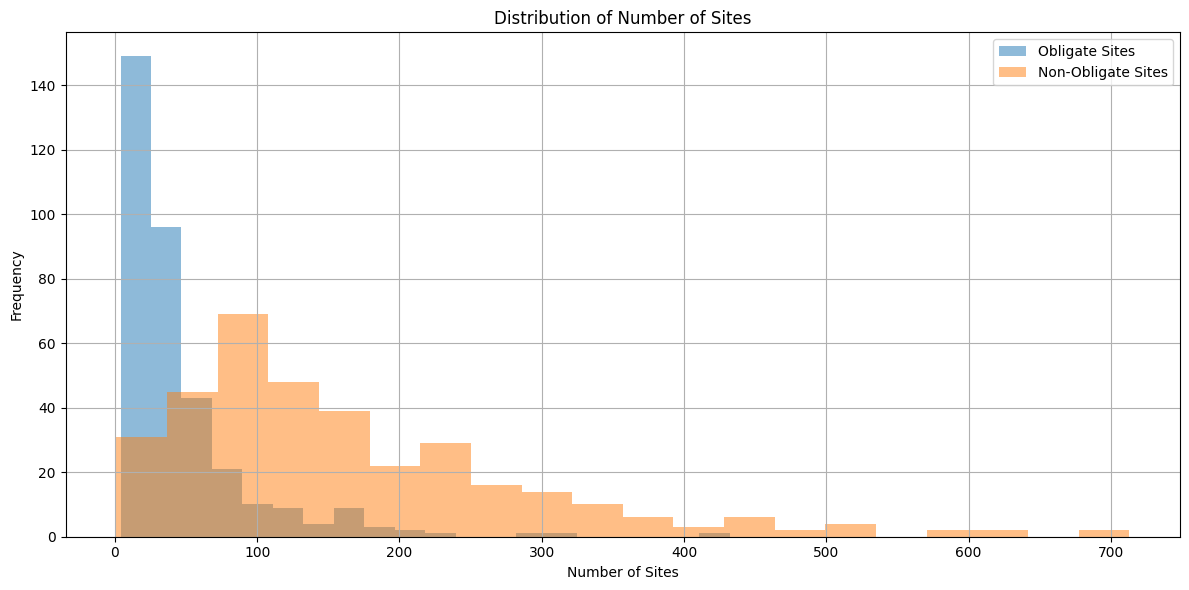

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths to your folders
labels_folder = '/content/labels'
pred_folder = '/content/pred'
obligate_folder = '/content/obligate_sites'
non_obligate_folder = '/content/non_obligate_sites'

# Function to create a mapping from lower-case file names to actual file paths
def create_file_mapping(folder):
    files = os.listdir(folder)
    file_map = {}
    for f in files:
        if f.endswith('.npy'):
            key = f.replace('.npy', '').lower()
            file_map[key] = f
    return file_map

# Create file mappings for each folder
labels_files = create_file_mapping(labels_folder)
pred_files = create_file_mapping(pred_folder)
obligate_files = create_file_mapping(obligate_folder)
non_obligate_files = create_file_mapping(non_obligate_folder)

# Get a list of PDBIDs from labels folder (lowercased)
pdbids = list(labels_files.keys())

# Lists to store metrics and counts
obligate_metrics = []
non_obligate_metrics = []
obligate_counts = []
non_obligate_counts = []

for pdbid in pdbids:
    # Load data
    try:
        # Get the actual file names from the mappings
        labels_file = labels_files[pdbid]
        preds_file = pred_files[pdbid]
        obligate_file = obligate_files[pdbid]
        non_obligate_file = non_obligate_files[pdbid]

        # Load data
        labels = np.load(os.path.join(labels_folder, labels_file))
        preds = np.load(os.path.join(pred_folder, preds_file))
        obligate_indices = np.load(os.path.join(obligate_folder, obligate_file))
        non_obligate_indices = np.load(os.path.join(non_obligate_folder, non_obligate_file))

        # Ensure indices are integers
        obligate_indices = obligate_indices.astype(int)
        non_obligate_indices = non_obligate_indices.astype(int)

        # Store counts of obligate and non-obligate sites
        obligate_counts.append(len(obligate_indices))
        non_obligate_counts.append(len(non_obligate_indices))

        # Extract labels and predictions for obligate sites
        labels_obligate = labels[obligate_indices]
        preds_obligate = preds[obligate_indices]

        # Extract labels and predictions for non-obligate sites
        labels_non_obligate = labels[non_obligate_indices]
        preds_non_obligate = preds[non_obligate_indices]

        # Compute metrics for obligate sites
        acc_obligate = accuracy_score(labels_obligate, preds_obligate)
        prec_obligate = precision_score(labels_obligate, preds_obligate, zero_division=0)
        rec_obligate = recall_score(labels_obligate, preds_obligate, zero_division=0)
        f1_obligate = f1_score(labels_obligate, preds_obligate, zero_division=0)
        obligate_metrics.append([acc_obligate, prec_obligate, rec_obligate, f1_obligate])

        # Compute metrics for non-obligate sites
        acc_non_obligate = accuracy_score(labels_non_obligate, preds_non_obligate)
        prec_non_obligate = precision_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        rec_non_obligate = recall_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        f1_non_obligate = f1_score(labels_non_obligate, preds_non_obligate, zero_division=0)
        non_obligate_metrics.append([acc_non_obligate, prec_non_obligate, rec_non_obligate, f1_non_obligate])

        # print(f'Successfully processed {pdbid}')
    except Exception as e:
        # print(f'Error processing {pdbid}: {e}')
        pass

# Convert lists to NumPy arrays for easier aggregation
obligate_metrics = np.array(obligate_metrics)
non_obligate_metrics = np.array(non_obligate_metrics)

# Compute average metrics over all PDBIDs
avg_obligate_metrics = np.mean(obligate_metrics, axis=0)
avg_non_obligate_metrics = np.mean(non_obligate_metrics, axis=0)

# Display the results
print("\nPerformance on Obligate Sites:")
print(f"Accuracy: {avg_obligate_metrics[0]:.4f}")
print(f"Precision: {avg_obligate_metrics[1]:.4f}")
print(f"Recall: {avg_obligate_metrics[2]:.4f}")
print(f"F1 Score: {avg_obligate_metrics[3]:.4f}\n")

print("Performance on Non-Obligate Sites:")
print(f"Accuracy: {avg_non_obligate_metrics[0]:.4f}")
print(f"Precision: {avg_non_obligate_metrics[1]:.4f}")
print(f"Recall: {avg_non_obligate_metrics[2]:.4f}")
print(f"F1 Score: {avg_non_obligate_metrics[3]:.4f}")

# Plotting the counts of obligate and non-obligate sites per PDBID
x = range(len(obligate_counts))  # Numerical indices for PDBIDs

plt.figure(figsize=(12, 6))
plt.plot(range(len(obligate_counts)), obligate_counts, label='Obligate Sites', marker='o')
plt.plot(range(len(non_obligate_counts)), non_obligate_counts, label='Non-Obligate Sites', marker='x')
plt.xlabel('PDBID Index')
plt.ylabel('Number of Sites')
plt.title('Number of Obligate and Non-Obligate Sites per PDBID')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot histograms to show the distribution of site counts
plt.figure(figsize=(12, 6))
plt.hist(obligate_counts, bins=20, alpha=0.5, label='Obligate Sites')
plt.hist(non_obligate_counts, bins=20, alpha=0.5, label='Non-Obligate Sites')
plt.xlabel('Number of Sites')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Sites')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


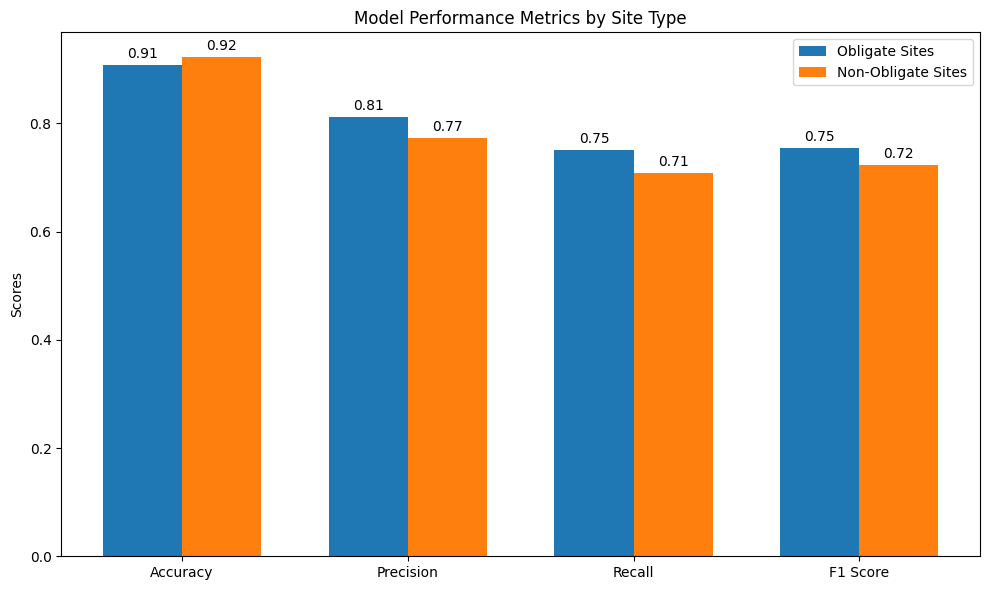

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'avg_obligate_metrics' and 'avg_non_obligate_metrics' are already computed
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create a DataFrame for easier plotting (optional)
import pandas as pd

data = {
    'Metrics': metric_names,
    'Obligate Sites': avg_obligate_metrics,
    'Non-Obligate Sites': avg_non_obligate_metrics
}

df = pd.DataFrame(data)

# Plotting
x = np.arange(len(metric_names))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, df['Obligate Sites'], width, label='Obligate Sites')
rects2 = ax.bar(x + width/2, df['Non-Obligate Sites'], width, label='Non-Obligate Sites')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Site Type')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Attach a text label above each bar displaying its height
def autolabel(rects):
    """Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # Offset text position
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


In [ ]:
!pip install nglview
!jupyter-nbextension enable nglview --py --sys-prefix
!pip install biopython
# Install py3Dmol (if not already installed)
!pip install py3Dmol


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 43.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary libraries
import os
import random
import requests
import numpy as np
from collections import defaultdict
from Bio import PDB
from Bio.PDB import NeighborSearch, PDBParser
from Bio.PDB.Polypeptide import is_aa
from Bio.SeqUtils import seq1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
import py3Dmol
from IPython.display import display, HTML
import base64

# -----------------------------
# User-defined parameters
# -----------------------------
PDBID = '1AK4'     # Change this to your desired PDB ID
chain_id = 'A'      # Change this to your desired chain
data_dir = '/content'  # Directory where your obligate/non_obligate and label/pred data is stored

# File naming convention (adjust if needed)
obligate_file = os.path.join(data_dir, f'obligate_sites/{PDBID.lower()}{chain_id}.npy')
non_obligate_file = os.path.join(data_dir, f'non_obligate_sites/{PDBID.lower()}{chain_id}.npy')
labels_file = os.path.join(data_dir, f'labels/{PDBID.lower()}{chain_id}.npy')
preds_file = os.path.join(data_dir, f'pred/{PDBID.lower()}{chain_id}.npy')
# -----------------------------

# Suppress warnings from Biopython
warnings.simplefilter('ignore', category=UserWarning)

pdb_filename = f"{PDBID}.pdb"

# Download the PDB file if it doesn't exist
if not os.path.isfile(pdb_filename):
    url = f"https://files.rcsb.org/download/{PDBID}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(pdb_filename, 'w') as f:
            f.write(response.text)
        print(f"Downloaded PDB file {pdb_filename}")
    else:
        raise ValueError(f"Failed to download PDB file for {PDBID}")
else:
    print(f"PDB file {pdb_filename} already exists.")

# Parse the PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure(PDBID, pdb_filename)

# Extract the specified chain
model = structure[0]
if chain_id not in model:
    raise ValueError(f"Chain {chain_id} not found in the PDB structure.")
chain = model[chain_id]

# Get all atoms in the structure
atoms = list(structure.get_atoms())
ns = NeighborSearch(atoms)

# Set the distance cutoff for interactions
distance_cutoff = 2.5  # Adjust as needed

# Find interacting residues
interacting_residues = set()
for residue in chain:
    if not is_aa(residue):
        continue
    for atom in residue:
        # Find neighboring atoms within the cutoff
        neighbors = ns.search(atom.get_coord(), distance_cutoff, level='R')
        for neighbor in neighbors:
            neighbor_residue = neighbor
            neighbor_chain = neighbor_residue.get_parent()
            if neighbor_chain != chain:
                interacting_residues.add(residue)
                break
        else:
            continue
        break

print(f"Total interacting residues found: {len(interacting_residues)}")

# Randomly split interacting residues into obligate and non-obligate sets
interacting_residues = list(interacting_residues)
random.shuffle(interacting_residues)
split_index = len(interacting_residues) // 2
obligate_residues = interacting_residues[:split_index]
non_obligate_residues = interacting_residues[split_index:]

# Load your known obligate/non-obligate residue numbers
if not (os.path.isfile(obligate_file) and os.path.isfile(non_obligate_file)):
    raise FileNotFoundError("Obligate or Non-obligate site files not found. Please check the file paths.")

obligate_res_nums = list(np.load(obligate_file))
non_obligate_res_nums = list(np.load(non_obligate_file))

print(f"Obligate sites (Residue Numbers): {obligate_res_nums}")
print(f"Non-obligate sites (Residue Numbers): {non_obligate_res_nums}")

# Extract sequence and map residue numbers to indices
seq = ""
residue_number_to_index = {}
index_to_residue_number = {}
index = 0
for residue in chain:
    if not is_aa(residue):
        continue
    res_name = residue.get_resname()
    res_num = residue.get_id()[1]
    try:
        one_letter_code = seq1(res_name)
    except Exception:
        one_letter_code = 'X'  # For unknown amino acids
    seq += one_letter_code
    residue_number_to_index[res_num] = index
    index_to_residue_number[index] = res_num
    index += 1

print(f"\nSequence length: {len(seq)}")
print(f"Sequence: {seq}")

# Load labels and predictions
if not (os.path.isfile(labels_file) and os.path.isfile(preds_file)):
    raise FileNotFoundError("Labels or Predictions file not found. Please check the file paths.")

labels = list(np.load(labels_file))
preds = list(np.load(preds_file))

# Compute metrics
def compute_metrics(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, zero_division=0)
    rec = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    return acc, prec, rec, f1

metrics = compute_metrics(labels, preds)

print("\nModel Performance:")
print(f"Accuracy: {metrics[0]:.4f}")
print(f"Precision: {metrics[1]:.4f}")
print(f"Recall: {metrics[2]:.4f}")
print(f"F1 Score: {metrics[3]:.4f}")

# Create coloring dictionaries for ground truth and predictions
ground_truth_colors = {}
prediction_colors = {}

for i in range(len(labels)):
    res_num = labels[i]

    # Ground truth colors
    if res_num in obligate_res_nums:
        ground_truth_colors[i] = 'red'
    elif res_num in non_obligate_res_nums:
        ground_truth_colors[i] = 'blue'
    else:
        ground_truth_colors[i] = 'gray'

for i in range(len(preds)):
    res_num = preds[i]
    # Ground truth colors
    if res_num in obligate_res_nums:
        prediction_colors[i] = 'red'
    elif res_num in non_obligate_res_nums:
        prediction_colors[i] = 'blue'
    else:
        prediction_colors[i] = 'gray'

def create_view(pdb_data, chain_id, residue_colors, title):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_data, 'pdb')
    # Remove any default styling
    view.setStyle({}, {})
    # Apply only spheres for the chain
    view.setStyle({'chain': chain_id}, {'sphere': {'color': 'gray', 'radius': 0.8}})

    # Color the specific residues
    for res_num, color in residue_colors.items():
        selection = {'chain': chain_id, 'resi': str(res_num)}
        view.addStyle(selection, {'sphere': {'color': color, 'radius': 0.8}})

    # Set the background color to white
    view.setBackgroundColor('white')
    # Add title as label
    view.addLabel(title, {'fontColor':'black', 'backgroundColor':'white', 'fontSize':14,
                          'position':[0,0,0], 'anchor':'topCenter'})

    # Get the center of the molecule for placing legends
    coords = []
    for atom in chain.get_atoms():
        coords.append(atom.get_coord())
    coords = np.array(coords)
    center = coords.mean(axis=0)
    center = center.astype(float)

    if title == 'Ground Truth':
        # For ground truth, show legend
        view.addLabel('Obligate Site', {'fontColor':'red', 'backgroundColor':'white', 'fontSize':12,
                                        'position':[center[0]+20, center[1], center[2]+10]})
        view.addLabel('Non-Obligate Site', {'fontColor':'blue', 'backgroundColor':'white', 'fontSize':12,
                                            'position':[center[0]+20, center[1], center[2]+5]})
        view.addLabel('Non-Interaction Site', {'fontColor':'gray', 'backgroundColor':'white', 'fontSize':12,
                                               'position':[center[0]+20, center[1], center[2]+15]})
    elif title == 'Prediction':
        # For predictions, show legend
        view.addLabel('Predicted Oblig. Site', {'fontColor':'red', 'backgroundColor':'white', 'fontSize':12,
                                                'position':[center[0]+20, center[1], center[2]+10]})
        view.addLabel('Predicted Non-Oblig. Site', {'fontColor':'blue', 'backgroundColor':'white', 'fontSize':12,
                                                    'position':[center[0]+20, center[1], center[2]+5]})
        view.addLabel('Predicted Non-Interact.', {'fontColor':'gray', 'backgroundColor':'white', 'fontSize':12,
                                                  'position':[center[0]+20, center[1], center[2]+15]})
    # Zoom to chain
    view.zoomTo({'chain': chain_id})
    return view

# Load the PDB structure text
with open(pdb_filename, 'r') as f:
    pdb_data = f.read()

# Create ground truth and prediction views
gt_view = create_view(pdb_data, chain_id, ground_truth_colors, 'Ground Truth')
pred_view = create_view(pdb_data, chain_id, prediction_colors, 'Prediction')

def show_views_side_by_side(view1, view2):
    div_style = "display: flex; align-items: center;"
    view1_html = view1._make_html()
    view2_html = view2._make_html()
    html = f"""<div style="{div_style}">
    <div>{view1_html}</div>
    <div>{view2_html}</div>
    </div>"""
    display(HTML(html))

# Display both views side by side
show_views_side_by_side(gt_view, pred_view)



PDB file 1AK4.pdb already exists.
Total interacting residues found: 6
Obligate sites (Residue Numbers): [130, 99, 68, 40, 9, 150, 119, 153, 122, 91, 60, 137, 110, 109, 78, 162, 4, 51, 19, 75, 38, 12, 90, 59, 16, 139, 164, 133, 163, 43, 151, 120, 89, 141, 61, 30, 114, 154, 113, 82, 8, 2, 33, 55, 54, 23, 132, 101, 14, 112, 131, 152, 72, 124, 50, 96, 65, 34, 142, 111, 80, 6, 84, 83, 52, 67, 36, 5, 144, 138, 107, 76, 48, 156, 125, 20, 128, 97, 66, 35, 88, 87, 7, 28, 106, 155, 0, 47, 148, 117, 86, 27, 136, 105, 31, 135, 157, 126, 77, 45, 98, 24, 18, 70, 39, 147, 85, 42, 11, 26, 159, 69, 121, 146, 118, 62, 56, 143, 81, 127, 53, 22, 21]
Non-obligate sites (Residue Numbers): [160, 32, 1, 103, 44, 13, 74, 46, 15, 123, 92, 73, 161, 25, 134, 102, 71, 93, 158, 37, 95, 64, 29, 79, 17, 94, 63, 145, 58, 104, 129, 116, 57, 100, 115, 41, 10, 149, 140, 108, 3, 49]

Sequence length: 165
Sequence: MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNG

In [ ]:
labels = list(np.load('/content/labels/1ak4A.npy'))
preds =list(np.load('/content/pred/1ak4A.npy'))
print(labels)
print(preds)
prediction_colors


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


{0: 'red', 1: 'blue'}

In [ ]:
# # Randomly split interacting residues into obligate and non-obligate
# interacting_residues = list(interacting_residues)
# random.shuffle(interacting_residues)
# split_index = len(interacting_residues) // 2
# obligate_residues = interacting_residues[:split_index]
# non_obligate_residues = interacting_residues[split_index:]

# # Get residue numbers
# obligate_res_nums = [res.get_id()[1] for res in obligate_residues]
# non_obligate_res_nums = [res.get_id()[1] for res in non_obligate_residues]'

non_obligate_residues,obligate_res_nums

([<Residue ASN het=  resseq=71 icode= >,
  <Residue ARG het=  resseq=55 icode= >,
  <Residue GLY het=  resseq=72 icode= >],
 [102, 63, 54])